<a href="https://colab.research.google.com/github/axcasas/Gubernatrix-cristata-iNaturalist-API/blob/main/iNaturalist_API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# iNaturalist API

In this notebook I will use iNaturalist API to get observations of a threatened specie in Argentina: *Gubernatrix cristata*.

Citizen science is fundamental in order to track and monitor species. My objective was to use iNaturalist API to make a map plot of all the observations of *Gubernatrix cristata*



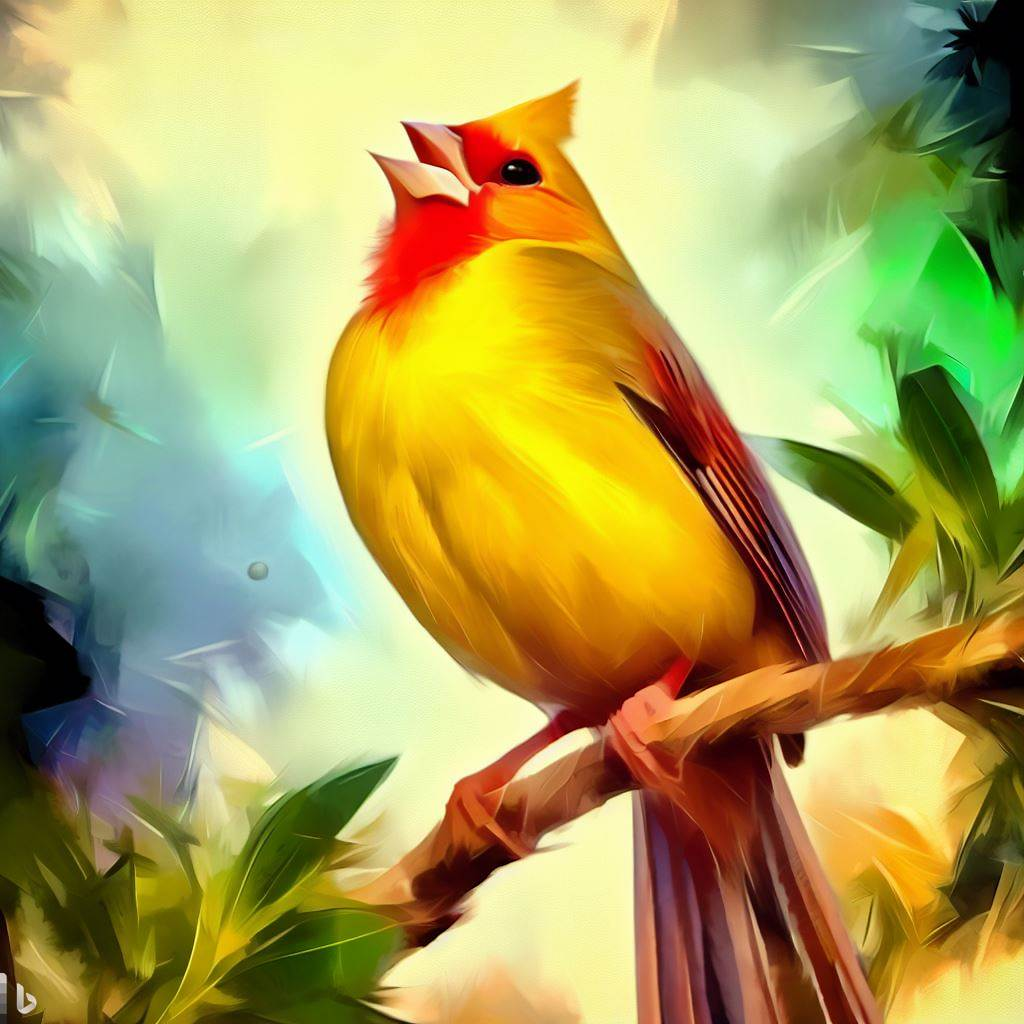

In [92]:
import requests # to access API
import json

In [93]:
url = "https://api.inaturalist.org/v1/observations"
response = requests.get(url)

# print status (200 is good to go)
print(response.status_code)

200


In [105]:
# to make a pretty way to see the json data

def jprint(obj):
    # create a formatted string of the Python JSON object
    text = json.dumps(obj, sort_keys=True, indent=4)
    print(text)

# jprint(response.json())

## Parameters

Note that if you print the following data (300 pages here), you would probably get an error as it is too large. If you still wanna see it you can reduce it to 10 pages. 



Here I'm using 300 results per page (iNaturalist Argentina has 271 observations for Gubernatrix cristata) in order to make a map plot of all the observations. 

In [95]:
params = {
    'taxon_id': 10717, # Gubernatrix cristata (cardenal amarillo)
    'place_id': 7190, # Argentina
    'per_page': 300 # limit to 300 results per page
}

To get the info for the taxon_id and place, you can google the species in iNaturalist, and go for the observations of that specie:

https://uk.inaturalist.org/observations?verifiable=true&taxon_id=10717&place_id=7190&preferred_place_id=6857&locale=en-GB


Look at how you can find taxon_id=10717 in the link, as well as place_id 7190

In [96]:
# store the request with the params in a variable
response = requests.get(url, params=params)

## Map

So far we have all the observations for Gubernatrix cristata. Now I want to make a map plot to see where they were. 

To do this, we can use the folium module as follows.

### Important

Latitude and longitude data are not in the top-level of the json dictionary, but nested within the "geojson" key. 

You can access them with obs['geojson']['coordinates'][1] for the latitude and obs['geojson']['coordinates'][0] for the longitude.

In [97]:
# store response.json() in a variable
data = response.json()

import folium # to plot a map

# create a map centered on Argentina (redefine location for your country of interest)
map = folium.Map(location=[-34.603722, -58.381592], zoom_start=4)

# add markers for each observation
for obs in data['results']:
    lat = obs['geojson']['coordinates'][1]
    lng = obs['geojson']['coordinates'][0]
    marker = folium.Marker([lat, lng])
    marker.add_to(map)

# display the map
map

Great! But if we wanna check the observation we have nothing to click on it. 

You can make your map interactive by defining 2 more variables:
1. An URL to go for the observation
2. A html for the popup info

In [98]:
# store response.json() in a variable
data = response.json()

import folium # to plot a map

# create a map centered on Argentina (redefine location for your country of interest)
map = folium.Map(location=[-34.603722, -58.381592], zoom_start=4)

# add markers for each observation
for obs in data['results']:
    lat = obs['geojson']['coordinates'][1]
    lng = obs['geojson']['coordinates'][0]
    obs_url = f"https://www.inaturalist.org/observations/{obs['id']}" # a link for the observation
    popup_html = f'<a href="{obs_url}" target="_blank">{obs_url}</a>' # popup a html for the obs_url
    marker = folium.Marker([lat, lng], popup=popup_html) # add the popup
    marker.add_to(map)

# display the map
map


Awesome! Now when you click on it, the map will popup a link for the observation in the iNaturalist page. 

## Creating a Dataframe to Analyze with Pandas

It is also possible to create a dataframe based on the information we got for our bird.

Here's how you can make it:

In [99]:
import pandas as pd

# create a list of dictionaries with the desired data
observations = []

for obs in data['results']:
    obs_dict = {
        'latitude': obs['geojson']['coordinates'][1],
        'longitude': obs['geojson']['coordinates'][0],
        'date': obs['observed_on_details']['date'],
        'observation_id': obs['id']
    }
    observations.append(obs_dict)

# create a pandas DataFrame from the list of dictionaries
df = pd.DataFrame(observations)
df.head()

,latitude,longitude,date,observation_id
0,-28.665680,-57.510872,2023-03-25,154100659
1,-28.723985,-57.539206,2019-03-28,153740174
2,-36.838852,-64.250022,2023-03-24,152823619
3,-37.316906,-64.591992,2023-03-28,152709606
4,-37.372500,-65.618011,2023-03-27,152603732


In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   latitude        200 non-null    float64
 1   longitude       200 non-null    float64
 2   date            200 non-null    object 
 3   observation_id  200 non-null    int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 6.4+ KB


### Analyzing by Date

I wanna see when were the observations made. So I use the loc function to see all the observations from 2015

In [101]:
# first we need to convert data to datetime so we can analyze it
df['date'] = pd.to_datetime(df['date'])
df.head()

,latitude,longitude,date,observation_id
0,-28.665680,-57.510872,2023-03-25,154100659
1,-28.723985,-57.539206,2019-03-28,153740174
2,-36.838852,-64.250022,2023-03-24,152823619
3,-37.316906,-64.591992,2023-03-28,152709606
4,-37.372500,-65.618011,2023-03-27,152603732


In [102]:
# use loc function to get all the obs from 2015
df_since2015 = df.loc[df['date'] >= '2015-01-01']
df_since2015.shape

(191, 4)

So we got 191 observations from 191, but I want to know how many of those are research grade (this means great serious quality).


To do this we first need to agregate a column for the obs quality. We can just make a True o False column.

In [103]:
# create a list of dictionaries with the desired data
observations = []

for obs in data['results']:
    obs_dict = {
        'latitude': obs['geojson']['coordinates'][1],
        'longitude': obs['geojson']['coordinates'][0],
        'date': obs['observed_on_details']['date'],
        'observation_id': obs['id'],
        'research_grade': obs['quality_grade'] == 'research' # research grade as true or false
    }
    observations.append(obs_dict)

# create a pandas DataFrame from the list of dictionaries
df = pd.DataFrame(observations)
df.head()

,latitude,longitude,date,observation_id,research_grade
0,-28.665680,-57.510872,2023-03-25,154100659,True
1,-28.723985,-57.539206,2019-03-28,153740174,True
2,-36.838852,-64.250022,2023-03-24,152823619,True
3,-37.316906,-64.591992,2023-03-28,152709606,True
4,-37.372500,-65.618011,2023-03-27,152603732,True


In [104]:
# we add the research grade condition
df_since2015 = df.loc[(df['date'] >= '2015-01-01') & (df['research_grade'] == True)]
df_since2015.shape

(187, 5)

So we have 187 observations since 2015 that are research grade quality

# Conclusion

- We use python to access the iNaturalist API to get all the observations of 

the *bird*. 

- We then plot all the observations in a map, restringed to Argentina, where there are projects to try to save them from extinction. 

- We create a small dataframe to analyze some data

- You can manipulate this code in order to get the observations of the species of interest.  